In [1]:
%%capture
import os

if os.getenv("COLAB_RELEASE_TAG"):
    !git clone https://github.com/ivanbrillo/tesiRFX
    %cd tesiRFX
    !rsync -a --exclude='*.ipynb' --exclude='*.git' ./ ../
    %cd ..
    !rm -rf tesiRFX
    
import tensorflow as tf
from tensorflow.keras import layers
import customLib.autoencoder_helper as helper
from customLib.betaVAE import VAE
from customLib.AE import AE, get_sequentials_outer

In [2]:
train, test = helper.get_splitted_np(win_size=80, alpha=40)

In [3]:
autoencoder = AE(*get_sequentials_outer())
autoencoder.set_trainable(False)
autoencoder.build(input_shape=(None, 1800, 1))
autoencoder.load_weights("./weights/convAE.h5")

In [10]:
def get_seq_fullAE():
    encoder = tf.keras.Sequential([
        autoencoder.encoder,
        layers.Dense(70, activation='linear'),
        layers.Dense(50, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(10, activation='linear'),
    ])

    decoder = tf.keras.Sequential([
        layers.Dense(10, activation='linear'),
        layers.Dense(30, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(70, activation='relu'),
        layers.Dense(80, activation='linear'),
        autoencoder.decoder,
    ])

    return encoder, decoder


fullVAE = VAE(*get_seq_fullAE(), latent_dim=2)

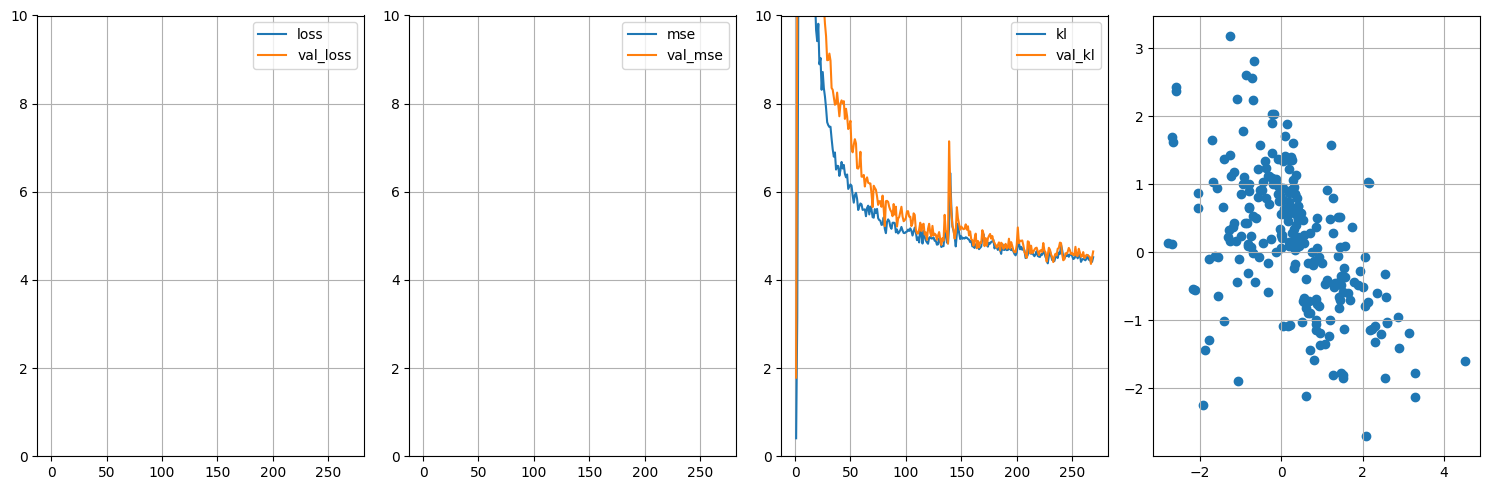

6/6 [==============================] - 1s 149ms/step - loss: 16.4066 - mse: 11.9314 - kl: 4.4751 - val_loss: 20.5278 - val_mse: 15.8811 - val_kl: 4.6467
Epoch 270/5000
8/8 [==============================] - 0s 4ms/step


In [ ]:
helper.train_and_evaluate(fullVAE, train, test, epochs_n=5000, apply_filter=True, show_latent=True, patience=500, batch_size=32, monitor="val_mse")